#### Import Library & Load Data

In [2]:
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

import optuna
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score , mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from vecstack import StackingTransformer

In [3]:
data = pd.read_csv('./data/Elderly.csv')
data.shape

(2092, 11)

In [4]:
data.head()

,Gender,Age,Religion,Job,Married,Edu,Health,Self_conf,Earn,Activity,target
0,0,67,1,2.0,1,1,2,2,1,1,1
1,0,68,2,3.0,3,0,2,1,1,1,1
2,0,66,3,4.0,1,2,2,1,2,0,1
3,0,68,3,2.0,3,0,1,1,0,1,3
4,0,73,3,1.0,3,0,1,1,0,0,1


#### EDA

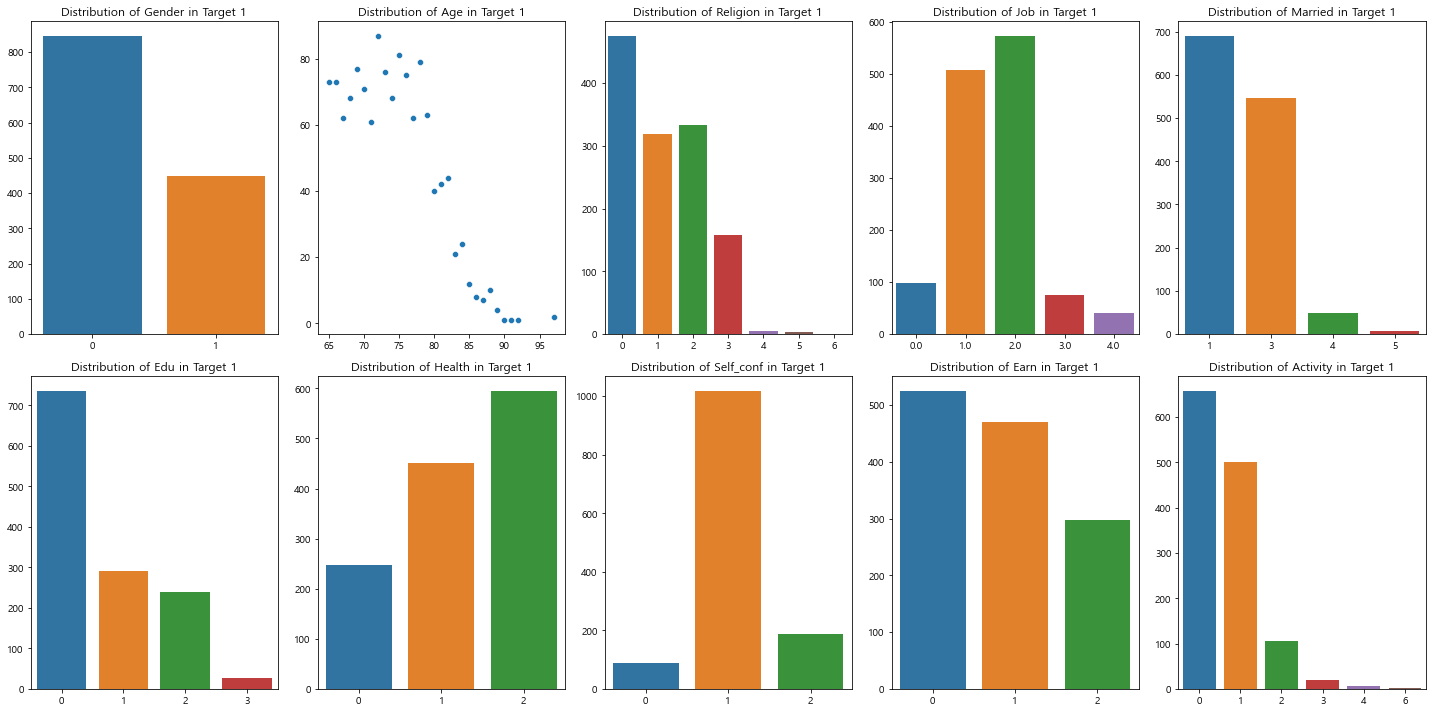

In [7]:
cols = data.drop(['target'], axis=1).columns
temp = data[data['target']==1]

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for idx, col in enumerate(cols[:5]):
    if col == 'Age':
        sns.scatterplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[0,idx])
    else:
        sns.barplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[0,idx])
    axes[0,idx].set_title(f'Distribution of {col} in Target 1')

for idx, col in enumerate(cols[5:]):
    sns.barplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[1,idx])
    axes[1,idx].set_title(f'Distribution of {col} in Target 1')

plt.tight_layout()
plt.show()

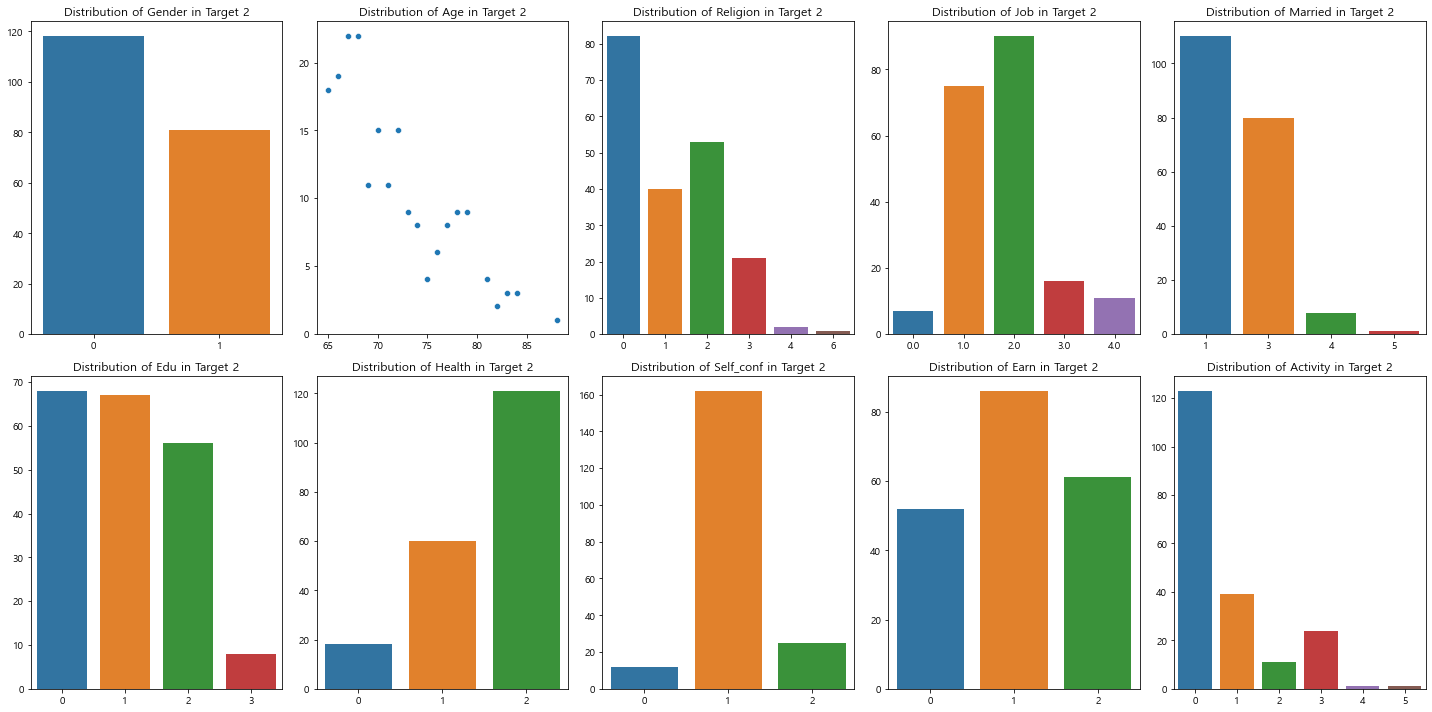

In [8]:
temp = data[data['target']==2]

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for idx, col in enumerate(cols[:5]):
    if col == 'Age':
        sns.scatterplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[0,idx])
    else:
        sns.barplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[0,idx])
    axes[0,idx].set_title(f'Distribution of {col} in Target 2')

for idx, col in enumerate(cols[5:]):
    sns.barplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[1,idx])
    axes[1,idx].set_title(f'Distribution of {col} in Target 2')

plt.tight_layout()
plt.show()

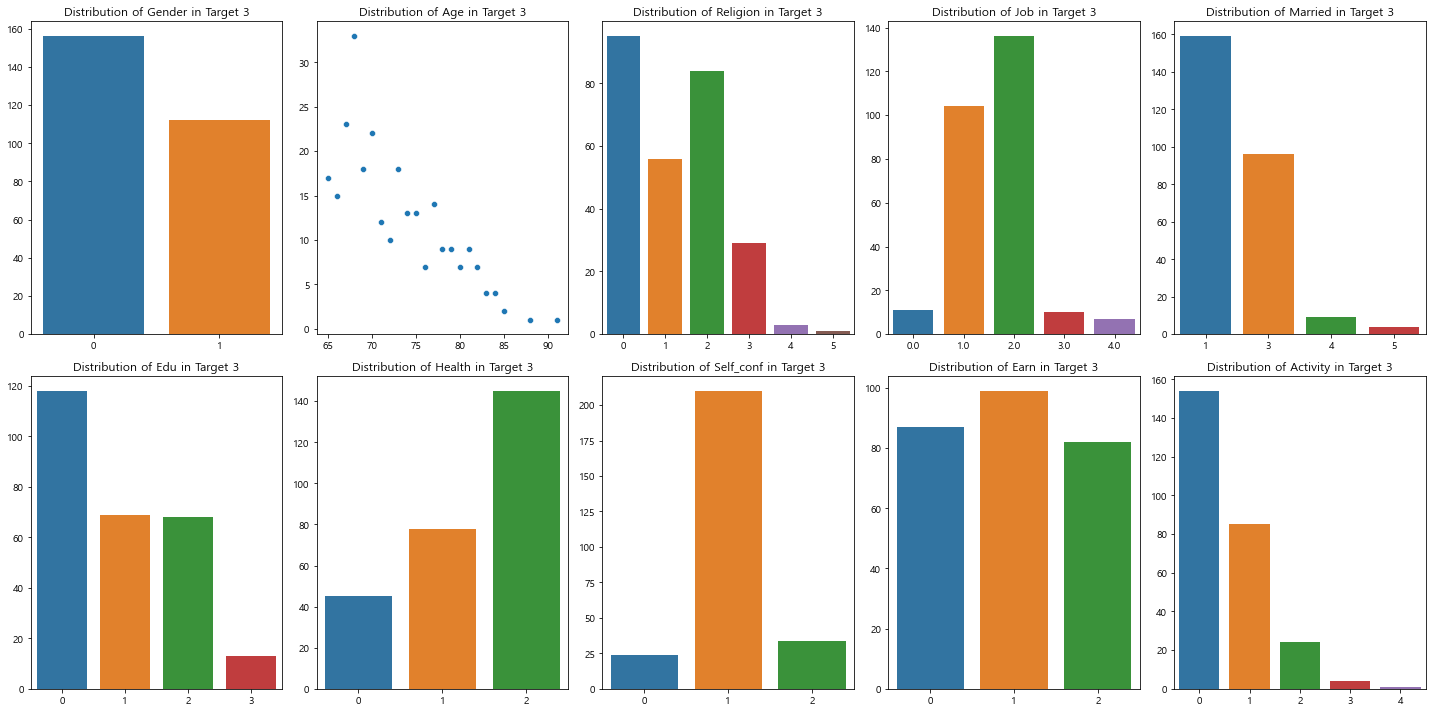

In [9]:
temp = data[data['target']==3]

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for idx, col in enumerate(cols[:5]):
    if col == 'Age':
        sns.scatterplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[0,idx])
    else:
        sns.barplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[0,idx])
    axes[0,idx].set_title(f'Distribution of {col} in Target 3')

for idx, col in enumerate(cols[5:]):
    sns.barplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[1,idx])
    axes[1,idx].set_title(f'Distribution of {col} in Target 3')

plt.tight_layout()
plt.show()

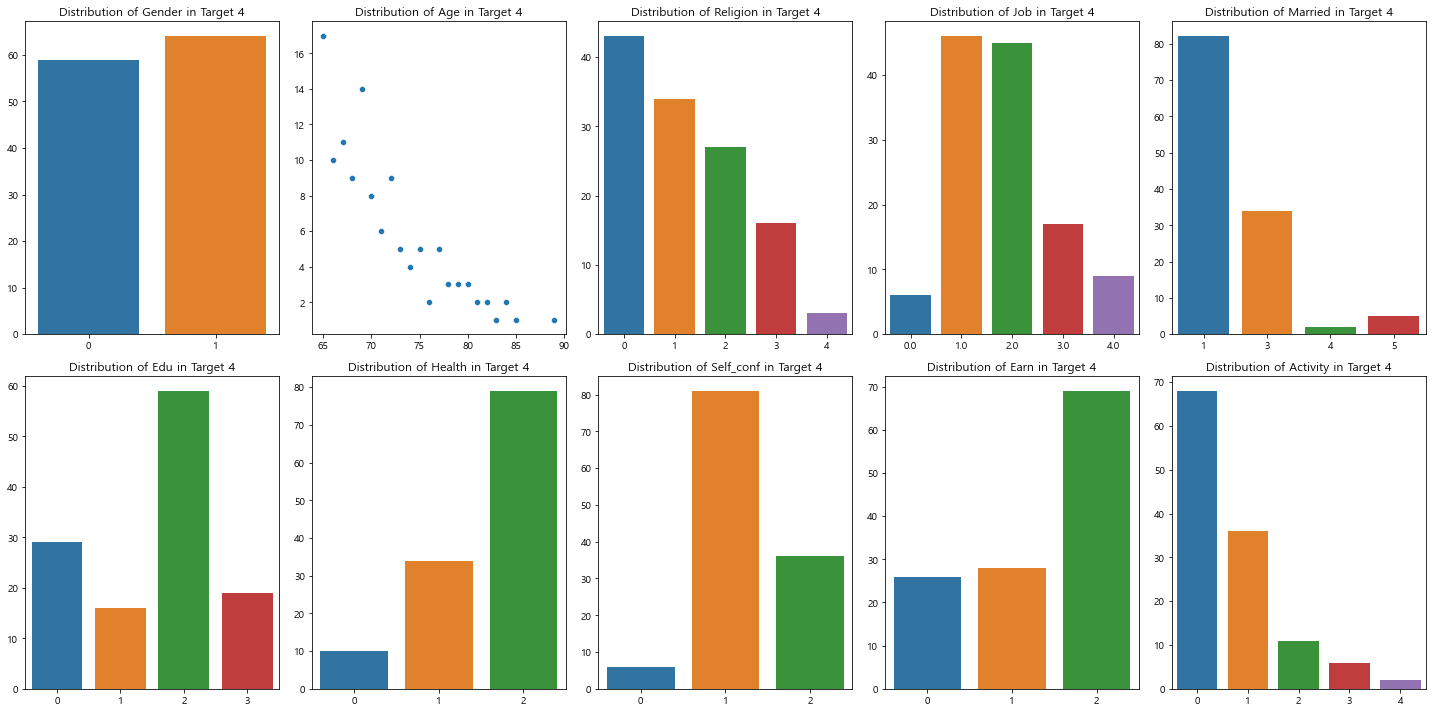

In [10]:
temp = data[data['target']==4]

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for idx, col in enumerate(cols[:5]):
    if col == 'Age':
        sns.scatterplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[0,idx])
    else:
        sns.barplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[0,idx])
    axes[0,idx].set_title(f'Distribution of {col} in Target 4')

for idx, col in enumerate(cols[5:]):
    sns.barplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[1,idx])
    axes[1,idx].set_title(f'Distribution of {col} in Target 4')

plt.tight_layout()
plt.show()

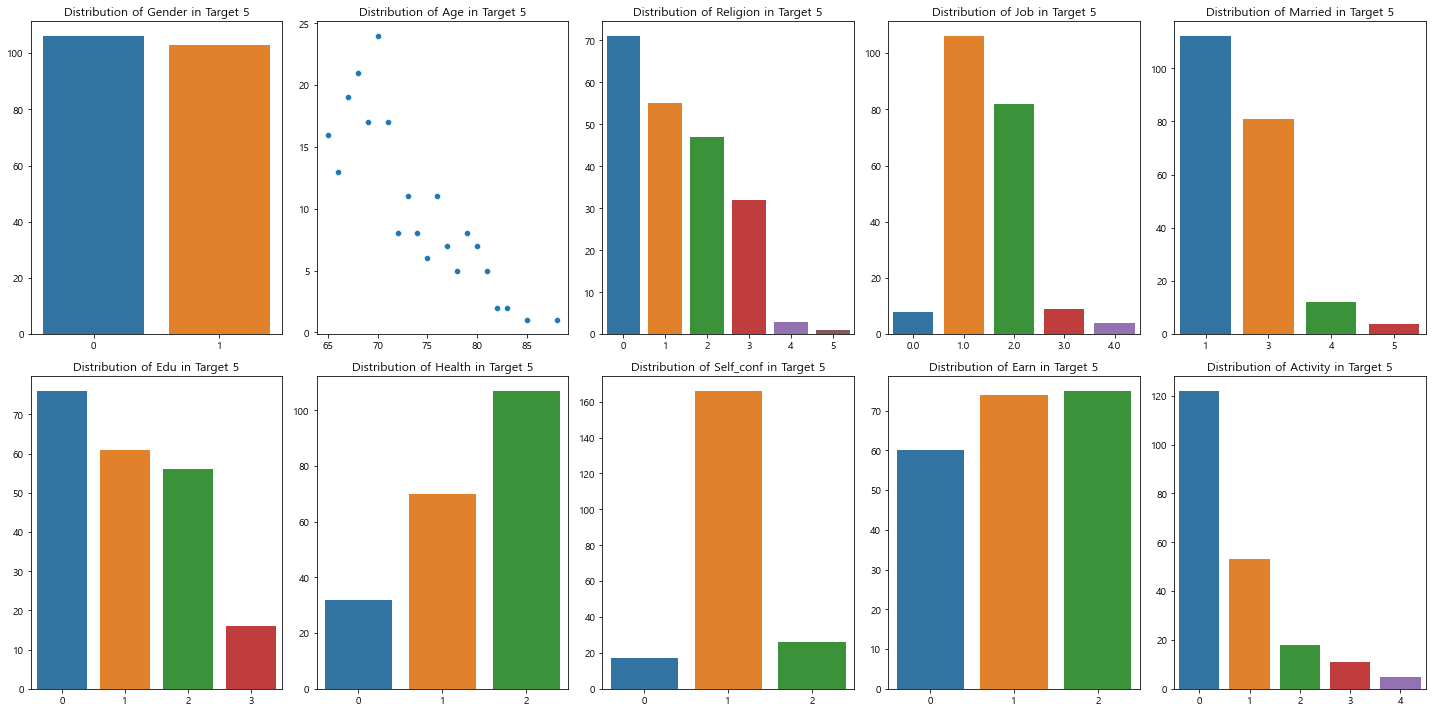

In [11]:
temp = data[data['target']==5]

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for idx, col in enumerate(cols[:5]):
    if col == 'Age':
        sns.scatterplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[0,idx])
    else:
        sns.barplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[0,idx])
    axes[0,idx].set_title(f'Distribution of {col} in Target 5')

for idx, col in enumerate(cols[5:]):
    sns.barplot(temp[col].value_counts().index, temp[col].value_counts().values, ax=axes[1,idx])
    axes[1,idx].set_title(f'Distribution of {col} in Target 5')

plt.tight_layout()
plt.show()

#### Oversampling

In [12]:
X = data.drop(['target'], axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2022)

In [13]:
y_train.value_counts()

1    1034
3     214
5     167
2     159
4      99
Name: target, dtype: int64

In [14]:
oversampling_instance = SMOTE(random_state=2022)
o_X_train, o_y_train = oversampling_instance.fit_sample(X_train, y_train)
o_y_train.value_counts()

4    1034
1    1034
5    1034
2    1034
3    1034
Name: target, dtype: int64

#### Modeling

In [45]:
# RandomSearch Tuning
tuned_models = []

clfs = [
(RandomForestClassifier(random_state=2022, n_jobs=-1),
    {'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 70, 90, 110],
    'max_depth': [3, 5, 7,10],
    'max_features': [0.8,0.85,0.9]}
),
(LGBMClassifier(random_state=2022, objective='multiclass', n_jobs=-1),
    {'learning_rate': np.arange(0.1, 0.6, 0.1),
        'n_estimators': [100,125,150,175,200],
        'max_depth': [3,5,7,9],
        'min_child_weight': [3,8,13],
        'subsample': [0.75,0.85,0.95]}
),
(XGBClassifier(random_state=2022, n_jobs=-1),
    {'learning_rate': [0.05,0.35,0.65,1.0],
        'n_estimators': [100,125,150,175,200],
        'max_depth': [3,5,7,9],
        'min_child_weight': [3,8,13],
        'subsample': [0.75, 0.85, 0.95],
        'gamma': [0,2,4]}
),
(CatBoostClassifier(random_seed=2022),
    {'learning_rate': [0.05, 0.35, 0.65, 1.0],
    'n_estimators': [100,125,150,175,200],
    'max_depth':[3,5,7,9]}
),
(LogisticRegression(random_state=2022),
    {'C': [100, 10, 1, 0.1, 0.01],
    'penalty':['none', 'l1', 'l2', 'elasticnet']}
)
]

for clf, param_grid in tqdm(clfs):
    rs = RandomizedSearchCV(clf, param_distributions = param_grid, scoring='accuracy', n_iter=30, random_state=2022, n_jobs=-1)
    scores = cross_val_score(rs, o_X_train, o_y_train, scoring='accuracy', cv = 5, n_jobs=-1)
    # 모델 이름
    clf_name = type(clf).__name__
    # 모델 성능저장
    clf_score = max(scores)
    # 모델, 모델성능 확인
    print(f'모델: {clf_name:30} 성능: {clf_score}')
    # 튜닝된 모델을 튜닝된 모델 리스트에 추가
    tuned_models.append((clf_name, rs, clf_score))

 20%|██        | 1/5 [02:21<09:25, 141.42s/it]

모델: RandomForestClassifier         성능: 0.7572533849129593


 40%|████      | 2/5 [02:53<03:51, 77.06s/it] 

모델: LGBMClassifier                 성능: 0.8065764023210832


 40%|████      | 2/5 [02:55<04:23, 87.92s/it]


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [44]:
evals = [(X_test, y_test)]
lgb = LGBMClassifier(random_state=2022, objective='multiclass')
lgb.fit(o_X_train, o_y_train, early_stopping_rounds=100,eval_metric='multi_logloss', eval_set=evals)
pred = lgb.predict(X_test)
accuracy_score(pred, y_test)

[1]	valid_0's multi_logloss: 1.55893
[2]	valid_0's multi_logloss: 1.52439
[3]	valid_0's multi_logloss: 1.49395
[4]	valid_0's multi_logloss: 1.47274
[5]	valid_0's multi_logloss: 1.4572
[6]	valid_0's multi_logloss: 1.4414
[7]	valid_0's multi_logloss: 1.42679
[8]	valid_0's multi_logloss: 1.41401
[9]	valid_0's multi_logloss: 1.40398
[10]	valid_0's multi_logloss: 1.39416
[11]	valid_0's multi_logloss: 1.38949
[12]	valid_0's multi_logloss: 1.38082
[13]	valid_0's multi_logloss: 1.3783
[14]	valid_0's multi_logloss: 1.37565
[15]	valid_0's multi_logloss: 1.37443
[16]	valid_0's multi_logloss: 1.3696
[17]	valid_0's multi_logloss: 1.37114
[18]	valid_0's multi_logloss: 1.36718
[19]	valid_0's multi_logloss: 1.36652
[20]	valid_0's multi_logloss: 1.36642
[21]	valid_0's multi_logloss: 1.36341
[22]	valid_0's multi_logloss: 1.36123
[23]	valid_0's multi_logloss: 1.36281
[24]	valid_0's multi_logloss: 1.36212
[25]	valid_0's multi_logloss: 1.36037
[26]	valid_0's multi_logloss: 1.36031
[27]	valid_0's multi_logl

0.4606205250596659

In [27]:
X_test

,Gender,Age,Religion,Job,Married,Edu,Health,Self_conf,Earn,Activity
1062,1,72,0,1.0,1,2,2,1,2,1
745,1,66,0,1.0,1,2,1,2,0,0
1706,1,72,0,2.0,1,0,1,1,2,3
302,1,67,1,1.0,1,3,2,2,1,0
538,1,68,3,1.0,1,3,2,1,2,0
...,...,...,...,...,...,...,...,...,...,...
816,0,66,0,2.0,1,2,1,1,2,0
222,1,65,2,4.0,1,3,2,1,0,0
234,1,78,1,1.0,1,0,0,0,1,0
1462,0,65,2,4.0,1,1,1,1,1,1


In [ ]:
# Bayesian Tuning

def objective(trial):
    
    # optuna.trial.Trial.suggest_categorical() for categorical parameters
    # optuna.trial.Trial.suggest_int() for integer parameters
    # optuna.trial.Trial.suggest_float() for floating point parameters    
    rf_n_estimators = trial.suggest_int("n_estimators", 500, 1500)
    rf_max_depth = trial.suggest_int("max_depth", 2, 100, log=True)
    rf_max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 100)
    rf_criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    

    classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                            max_depth=rf_max_depth,
                                            max_leaf_nodes=rf_max_leaf_nodes,
                                            criterion=rf_criterion,
                                            n_jobs=-1, 
                                            random_state=2020)

    score = model_selection.cross_val_score(classifier_obj, X, y, scoring='roc_auc', cv=5, n_jobs=-1)
    roc_auc = score.mean()
    return roc_auc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=72)
print(study.best_trial)

model = RandomForestClassifier(**study.best_params, n_jobs=-1, random_state=2020)
model.fit(X, y)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)